# Assignment 2: Computational Methods in Finance - MFI 8302
### Strathmore University

#### Lec: Dr. Samuel Chege

#### Name: Ed Joel Odhiambo

#### Adm. no: 095892

# Question 1

## European Call via Monte Carlo under GB

In [3]:
# Imports
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (7.2, 5.0)
plt.rcParams["axes.grid"] = True
np.set_printoptions(suppress=True, linewidth=140)


# Shared helpers
def bs_call_price(S, K, r, sigma, T):
    if sigma <= 0 or T <= 0:
        return max(0.0, S - K*math.exp(-r*T))
    d1 = (math.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return S*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)

def mc_from_ST(ST, K, r, T):
    disc = math.exp(-r*T)
    payoff = np.maximum(ST - K, 0.0)
    disc_payoff = disc * payoff
    est = disc_payoff.mean()
    sd  = disc_payoff.std(ddof=1)
    se  = sd / math.sqrt(len(ST))
    ci95 = (est - 1.96*se, est + 1.96*se)
    return est, se, ci95, sd


In [4]:
# Inputs
# Given parameters
S0   = 100.0
K    = 100.0   # strike (E in the statement)
r    = 0.05
sigma= 0.20
T    = 0.5     # 6 months

# Monte Carlo controls
Ms   = [500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]
m_euler = 200          # Euler time steps on [0,T] (tunable)
seed = 2025
rng  = np.random.default_rng(seed)

BS = bs_call_price(S0, K, r, sigma, T)
print("Black–Scholes (benchmark) =", BS)


Black–Scholes (benchmark) = 6.888728577680624


### a) Simulate paths via Euler discretization and estimate price

In [5]:
def simulate_ST_euler(M, S0, r, sigma, T, m, rng):
    dt = T/m
    sqdt = math.sqrt(dt)
    S = np.full(M, S0, dtype=float)
    Z = rng.standard_normal((M, m))
    for k in range(m):
        S *= (1.0 + r*dt + sigma*sqdt*Z[:, k])
    return S

rows_euler = []
for M in Ms:
    ST = simulate_ST_euler(M, S0, r, sigma, T, m_euler, rng)
    est, se, ci, sd = mc_from_ST(ST, K, r, T)
    rows_euler.append((M, est, se, ci))
    print(f"Euler MC: M={M:7d} | Price={est:.6f}  SE={se:.6f}  CI=({ci[0]:.6f},{ci[1]:.6f})")


Euler MC: M=    500 | Price=6.426722  SE=0.427567  CI=(5.588691,7.264752)
Euler MC: M=   1000 | Price=7.036544  SE=0.310982  CI=(6.427019,7.646069)
Euler MC: M=   2000 | Price=6.697113  SE=0.212489  CI=(6.280634,7.113593)
Euler MC: M=   5000 | Price=6.931798  SE=0.137516  CI=(6.662267,7.201329)
Euler MC: M=  10000 | Price=7.119666  SE=0.099729  CI=(6.924198,7.315134)
Euler MC: M=  20000 | Price=6.881179  SE=0.069204  CI=(6.745539,7.016820)
Euler MC: M=  50000 | Price=6.900363  SE=0.043888  CI=(6.814342,6.986383)
Euler MC: M= 100000 | Price=6.959361  SE=0.031007  CI=(6.898588,7.020134)


### b) Graphical comparison vs the Black–Scholes price (Euler MC)

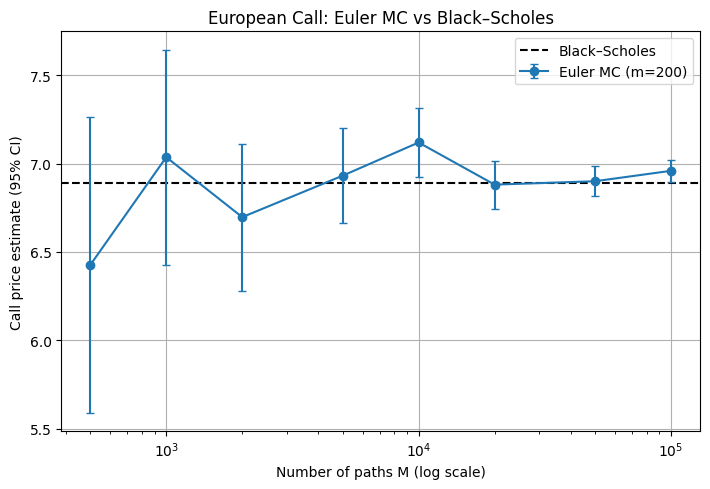

In [12]:
euler_means = [r[1] for r in rows_euler]
euler_errs  = [1.96*r[2] for r in rows_euler]   

plt.figure()
plt.axhline(BS, color='k', linestyle='--', label='Black–Scholes')
plt.errorbar(Ms, euler_means, yerr=euler_errs, fmt='o-', capsize=3, label=f'Euler MC (m={m_euler})')
plt.xscale('log')
plt.xlabel('Number of paths M (log scale)')
plt.ylabel('Call price estimate (95% CI)')
plt.title('European Call: Euler MC vs Black–Scholes')
plt.legend()
plt.tight_layout()
plt.show()


### c) Use the explicit GBM solution for ST​ and re-estimate

In [13]:
def simulate_ST_explicit(M, S0, r, sigma, T, rng):
    Z = rng.standard_normal(M)
    return S0 * np.exp((r - 0.5*sigma**2)*T + sigma*math.sqrt(T)*Z)

rows_explicit = []
for M in Ms:
    ST = simulate_ST_explicit(M, S0, r, sigma, T, rng)
    est, se, ci, sd = mc_from_ST(ST, K, r, T)
    rows_explicit.append((M, est, se, ci))
    print(f"Explicit MC: M={M:7d} | Price={est:.6f}  SE={se:.6f}  CI=({ci[0]:.6f},{ci[1]:.6f})")


Explicit MC: M=    500 | Price=6.820354  SE=0.446949  CI=(5.944333,7.696375)
Explicit MC: M=   1000 | Price=6.613562  SE=0.295796  CI=(6.033803,7.193321)
Explicit MC: M=   2000 | Price=6.855737  SE=0.221756  CI=(6.421096,7.290378)
Explicit MC: M=   5000 | Price=6.796987  SE=0.133590  CI=(6.535151,7.058823)
Explicit MC: M=  10000 | Price=7.030259  SE=0.099334  CI=(6.835563,7.224954)
Explicit MC: M=  20000 | Price=6.931455  SE=0.069369  CI=(6.795491,7.067419)
Explicit MC: M=  50000 | Price=6.856432  SE=0.043701  CI=(6.770778,6.942086)
Explicit MC: M= 100000 | Price=6.899540  SE=0.031080  CI=(6.838623,6.960457)


### d) Compare Euler vs Explicit MC

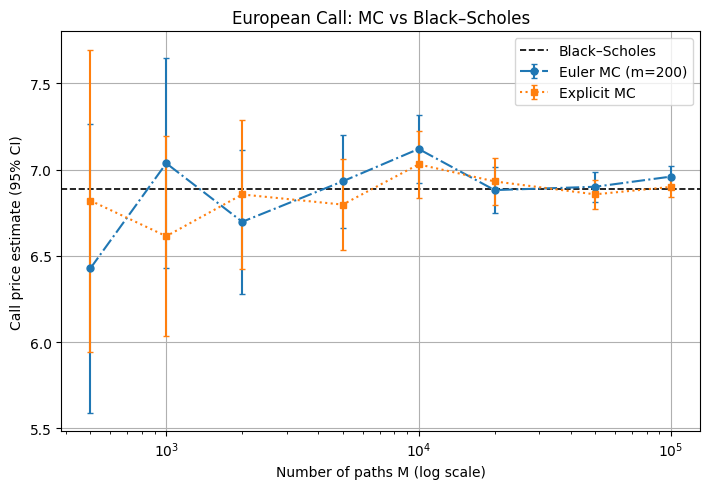

In [15]:
# --- Euler vs Explicit vs Black–Scholes with lighter styles ---
plt.figure()

# Black–Scholes reference
plt.axhline(BS, color='k', linestyle='--', linewidth=1.2, label='Black–Scholes')

# Euler MC
plt.errorbar(
    Ms, euler_means, yerr=euler_errs,
    fmt='o', linestyle='-.', markersize=5, capsize=2,
    color='tab:blue', label=f'Euler MC (m={m_euler})'
)

# Explicit MC
plt.errorbar(
    Ms, exp_means, yerr=exp_errs,
    fmt='s', linestyle=':', markersize=5, capsize=2,
    color='tab:orange', label='Explicit MC'
)

# Axes and labels
plt.xscale('log')
plt.xlabel('Number of paths M (log scale)')
plt.ylabel('Call price estimate (95% CI)')
plt.title('European Call: MC vs Black–Scholes')
plt.legend()
plt.tight_layout()
plt.show()
